In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
pd.options.display.max_rows = 999
import sys
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

sys.path.append(gh_dir+'asurv/')

import asurv

In [2]:
# Setup the figures
style='paper'
execfile('/Users/ttshimiz/Dropbox/Research/figure_setup.py')

##Get all of the data for the BAT AGN

In [3]:
# Upload the fitting results for the C12 model
bat_casey = pd.read_csv('../data/bat-agn-c12-params.csv', index_col=0)
herschel_data = pd.read_csv(data_dir+'bat_herschel.csv', index_col=0,
                            na_values=0)
plw_flag = herschel_data['PLW_flag']
herschel_data['PLW'][plw_flag == 'AD'] = np.nan
bat_casey['PLW'] = herschel_data['PLW']
# Remove 'bad' sources
bad_sources = np.array(['PICTORA', '3C111.0', '3C120',
                        '2MASXJ23272195+1524375', 'PKS2331-240',
                        'HB890241+622', 'Mrk3'])
bat_casey = bat_casey.drop(bad_sources)
#bat_casey.loc['UGC06728', 'lir_sf'] += 2.0
#bat_casey.loc['UGC06728', 'mdust'] += 2.0

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)
bat_casey['Dist'] = bat_info['Dist_[Mpc]']
#bat_info.loc['UGC06728', 'Dist_[Mpc]'] = 292.0

# We need to calculate stellar masses for the BAT AGN using the method in Zibetti et al 2009 since this method was used
# for both the KINGFISH and HRS galaxies. I use the AGN subtracted SDSS photometry from Koss et al 2011 and the g-i color
# relation for the stellar masses.
bat_koss = pd.read_csv(data_dir+'bat_koss11.csv', index_col=0)
bat_koss.loc[bat_koss['griz_cont']=='Y', 'SDSS_i_Koss'] = np.nan
bi = 1.8e-10
bat_koss['SDSS_i_flux'] = 3631.*(2*bi*np.sinh(-np.log(10)*bat_koss['SDSS_i_Koss']/2.5 - np.log(bi)))
bat_koss['SDSS_Li'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*(3.0e10/0.7480e-4)*bat_koss['SDSS_i_flux']*10**(-23)
bat_casey['Mstar'] = (-0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) +
                     np.log10(bat_koss['SDSS_Li']/3.846e33))

/Users/ttshimiz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Get all of the data for the HRS sample

In [4]:
# Upload the HRS fits
hrs_casey = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_hrs.csv', index_col=0)
hrs_casey_undetected = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected_hrs.csv', index_col=0)
hrs_all = pd.concat([hrs_casey, hrs_casey_undetected])
hrs_all.loc[hrs_casey_undetected.index, 'Flag'] = -1
hrs_all.loc[hrs_casey.index, 'Flag'] = 0
# Remove the BAT AGN in the HRS
hrs_all = hrs_all.drop([4,144,288,296])

# Upload the HRS info
hrs_info = pd.read_table(gh_dir+'hrs-data/hrs_photometry.txt', delimiter='\t', index_col=0, na_values=-99.99)
hrs_info = hrs_info.drop([4,144,288,296])

# HRS gas-rich galaxies
hrs_gas_rich = np.array([np.loadtxt(gh_dir+'hrs-data/hrs_gas_rich_numbers.txt')], dtype = int)[0]

hrs_all['Mstar'] = hrs_info['logMstart']
hrs_all['Dist'] = hrs_info['Dist_Mpc']
hrs_all['S500'] = hrs_info['S500']

# Upload the IDs for our mass selected HRS sample
mass_select = pd.read_csv('mass_selected_hrs_ids.csv', index_col=0)
hrs_mass_select = pd.DataFrame(index=mass_select.index, columns=hrs_all.columns)

for n in mass_select.index:
    
    hrs_mass_select.loc[n] = hrs_all.loc[np.int(mass_select.loc[n, 'HRS ID'])]
    hrs_mass_select.loc[n, 'HRS ID'] = np.int(mass_select.loc[n, 'HRS ID'])

##Get all of the data for the KINGFISH galaxies

In [5]:
# Upload the KINGFISH fits
kf_casey = pd.read_csv(casey_dir+'kingfish_beta_fixed_2_wturn_gaussianPrior/final_fit_results_kingfish_casey.csv',
                       index_col=0)
kf_casey_undetected = pd.read_csv(casey_dir+'kingfish_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected_kingfish.csv', index_col=0)

# Upload the KINGFISH info
kf_info = pd.read_table('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/kingfish_data.txt',
                        index_col=0, delimiter='\t')

# Remove the KINGFISH galaxies with stellar mass less 10^9.47 which is the 
# minimum mass in the BAT sample.
kf_casey['Mstar'] = kf_info['Mstar']
kf_casey_undetected['Mstar'] = kf_info['Mstar']
kf_low_mass = kf_casey['Mstar'] <= 9.47
kf_casey = kf_casey[~kf_low_mass]

In [6]:
# Calculate SFR for all three samples
bat_casey['SFR'] = bat_casey['lir_sf'] + np.log10(3.846e33) - np.log10(2.57e43)
hrs_casey['SFR'] = hrs_casey['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43)
hrs_mass_select['SFR'] = hrs_mass_select['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43)
hrs_casey_undetected['SFR'] = hrs_casey_undetected['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43)
kf_casey['SFR'] = kf_casey['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43) 
kf_casey_undetected['SFR'] = kf_casey_undetected['lir_total'] + np.log10(3.846e33) - np.log10(2.57e43)

## Dust Mass, Dust Temperature, and SFR Comparison

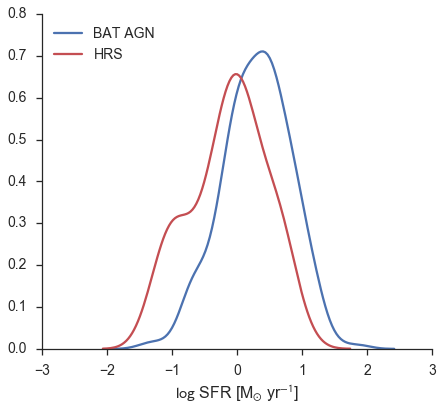

In [9]:
#fig = plt.figure(figsize=(1.2*textwidth, 1./2.*1.5*textwidth))
fig = plt.figure(figsize=(7, 6))
#ax1 = fig.add_subplot(221)
#sn.kdeplot(bat_casey['mdust'][bat_casey['mdust_flag'] != -1].dropna(), label='BAT AGN', ax=ax1, color='b')
#sn.kdeplot(hrs_mass_select['mdust'][hrs_mass_select['Flag'] == 0].dropna(), label='HRS', ax=ax1, color='r')
#sn.kdeplot(kf_casey['mdust'].dropna(), label='KINGFISH', ax=ax1, color='k')
#sn.kdeplot(bat_casey['mdust'][bat_casey['mdust_flag'] == -1].dropna(), ax=ax1, ls='dashed', color='b')
#sn.kdeplot(hrs_mass_select['mdust'][hrs_mass_select['Flag'] == -1].dropna(), ax=ax1, ls='dashed', color='r')
#plt.xlabel(r'$\log\,M_{\rm dust}$ [M$_{\odot}$]')
#plt.legend([])
#sn.despine()

#ax2 = fig.add_subplot(222)
#sn.kdeplot(bat_casey['tdust'][bat_casey['agn_frac'] < 0.2].dropna(), label='BAT AGN', color='b', ax=ax2)
#sn.kdeplot(hrs_mass_select['tdust'][hrs_mass_select['Flag'] == 0].dropna(), label='HRS', color='r', ax=ax2)
#sn.kdeplot(kf_casey['tdust'].dropna(), label='KINGFISH', color='k', ax=ax2)
#plt.xlabel(r'$T_{\rm dust}$ [K]')
#plt.legend(loc='upper right')
#sn.despine()

ax3 = fig.add_subplot(111)
sn.kdeplot(bat_casey['SFR'][bat_casey['lir_sf_flag'] != -1].dropna(), label='BAT AGN', color='b', ax=ax3)
sn.kdeplot(hrs_mass_select['SFR'][hrs_mass_select['Flag'] == 0].dropna(), label='HRS', color='r', ax=ax3)
#sn.kdeplot(kf_casey['SFR'].dropna(), label='KINGFISH', color='k', ax=ax3)
#sn.kdeplot(bat_casey['SFR'][bat_casey['lir_sf_flag'] == -1].dropna(), color='b', ax=ax3, ls='dashed', label='_nolabel')
#sn.kdeplot(hrs_mass_select['SFR'][hrs_mass_select['Flag'] == -1].dropna(), color='r', ax=ax3, ls='dashed', label='_nolabel')
plt.xlabel(r'$\log$ SFR [M$_{\odot}$ yr$^{-1}$]')
plt.legend(loc='upper left')
sn.despine()

#ax4 = fig.add_subplot(234)
#sn.kdeplot((bat_casey['mdust'] - bat_casey['Mstar'])[bat_casey['lir_sf_flag'] != -1].dropna(), label='BAT AGN', color='b', ax=ax4)
#sn.kdeplot((hrs_casey['mdust'] - hrs_casey['Mstar']).dropna(), label='HRS', color='r', ax=ax4)
#sn.kdeplot((kf_casey['mdust'] - kf_casey['Mstar']).dropna(), label='KINGFISH', color='k', ax=ax4)
#sn.kdeplot((bat_casey['mdust'] - bat_casey['Mstar'])[bat_casey['lir_sf_flag'] == -1].dropna(), color='b', ax=ax4, ls='dashed')
#sn.kdeplot((hrs_casey_undetected['mdust'] - hrs_casey_undetected['Mstar']).dropna(), label='HRS', color='r', ax=ax4, ls='dashed')
#plt.xlabel(r'$\log\,(M_{\rm dust}/M_{\rm star})$')
#plt.legend([])
#sn.despine()


#ax5 = fig.add_subplot(235)
#sn.kdeplot((bat_casey['tdust']/bat_casey['Mstar']).dropna(), label='BAT AGN', color='b', ax=ax5)
#sn.kdeplot((hrs_casey['tdust']/hrs_casey['Mstar']).dropna(), label='HRS', color='r', ax=ax5)
#sn.kdeplot((kf_casey['tdust']/kf_casey['Mstar']).dropna(), label='KINGFISH', color='k', ax=ax5)
#plt.xlabel(r'$T_{\rm dust}/\log\,M_{\rm star}$')
#plt.legend([])
#sn.despine()

#ax6 = fig.add_subplot(236)
#sn.kdeplot((bat_casey['SFR'] - bat_casey['Mstar']).dropna(), label='BAT AGN', color='b', ax=ax6)
#sn.kdeplot((hrs_casey['SFR'] - hrs_casey['Mstar']).dropna(), label='HRS', color='r', ax=ax6)
#sn.kdeplot((kf_casey['SFR'] - kf_casey['Mstar']).dropna(), label='KINGFISH', color='k', ax=ax6)
#sn.kdeplot((bat_casey['SFR'] - bat_casey['Mstar'])[bat_casey['lir_sf_flag'] == -1].dropna(), color='b', ax=ax6, ls='dashed')
#sn.kdeplot((hrs_casey_undetected['SFR'] - hrs_casey_undetected['Mstar']).dropna(), label='HRS', color='r', ax=ax6, ls='dashed')
#plt.legend([])
#plt.xlabel(r'sSFR [yr$^{-1}$]')
#sn.despine()

fig.subplots_adjust(wspace=0.3, hspace=0.4)

fig.savefig('/Users/ttshimiz/Dropbox/Research/Talks/Ringberg2016/sfr_comparison_mass_select_hrs.pdf', bbox_inches='tight')

##Analysis of the distributions for each sample

Calculation of the median and spread for each sample in Mdust, Tdust, and SFR. Also normalize the values with stellar mass. Use survival tests to determine whether they come from same parent distribution. For now use only the detected objects. This shouldn't be too bad since the BAT AGN only have 35 that aren't detected, HRS has 27, and KINGFISH has 2.

In [9]:
len(hrs_mass_select['mdust'])

122

In [12]:
bat_agn_mdust_med = np.mean(bat_casey['mdust'])
hrs_mdust_med = np.mean(hrs_mass_select['mdust'][hrs_mass_select['Flag']==0])
#kf_mdust_med = np.mean(kf_casey[~kf_low_mass]['mdust'])

bat_agn_mdust_std = np.std(bat_casey['mdust'])
hrs_mdust_std = np.std(hrs_mass_select['mdust'][hrs_mass_select['Flag']==0])
#kf_mdust_std = np.std(kf_casey[~kf_low_mass]['mdust'])

print 'Mean log(Dust Masses):'
print 'BAT AGN: ', bat_agn_mdust_med, '+/-', bat_agn_mdust_std
print 'HRS: ', hrs_mdust_med, '+/-', hrs_mdust_std
#print 'KINGFISH: ', kf_mdust_med, '+/-', kf_mdust_std

Mean log(Dust Masses):
BAT AGN:  7.30331094283 +/- 0.616101243058
HRS:  7.104931924 +/- 0.737233516566


In [17]:
bat_tdust_med = np.median(bat_casey['tdust'].dropna())
hrs_tdust_med = np.median(hrs_mass_select['tdust'].dropna())
#kf_tdust_med = np.mean(kf_casey[~kf_low_mass]['tdust'])

bat_agn_tdust_std = np.std(bat_casey['tdust'])
hrs_tdust_std = np.std(hrs_mass_select['tdust'])
#kf_tdust_std = np.std(kf_casey[~kf_low_mass]['tdust'])

bat_tdust_percentiles = np.percentile(bat_casey['tdust'].dropna(), q=[16, 84])
hrs_tdust_percentiles = np.percentile(hrs_mass_select['tdust'].dropna(), q=[16, 84])
#print 'Mean Dust Temperatures:'
#print 'BAT AGN: ', bat_agn_tdust_med, '+/-', bat_agn_tdust_std/np.sqrt(len(bat_casey['tdust']))
#print 'HRS: ', hrs_tdust_med, '+/-', hrs_tdust_std/np.sqrt(len(hrs_casey['tdust']))
#print 'KINGFISH: ', kf_tdust_med, '+/-', kf_tdust_std/np.sqrt(len(kf_casey['tdust']))

print 'Median Dust Temperatures with 68% CI:'
print 'BAT: ', bat_tdust_med, '(', bat_tdust_percentiles[0],'-', bat_tdust_percentiles[1],')'
print 'HRS: ', hrs_tdust_med, '(', hrs_tdust_percentiles[0],'-', hrs_tdust_percentiles[1],')'

Median Dust Temperatures with 68% CI:
BAT:  23.7898143865 ( 19.4357331729 - 27.5468747822 )
HRS:  21.50172917 ( 19.3918087212 - 24.6192829404 )


In [10]:
bat_agn_sfr_med = np.mean(bat_casey['SFR'])
hrs_sfr_med = np.mean(hrs_casey['SFR'])
kf_sfr_med = np.mean(kf_casey[~kf_dwarfs]['SFR'])

bat_agn_sfr_std = np.std(bat_casey['SFR'])
hrs_sfr_std = np.std(hrs_casey['SFR'])
kf_sfr_std = np.std(kf_casey[~kf_dwarfs]['SFR'])

print 'Mean log(SFR):'
print 'BAT AGN: ', bat_agn_sfr_med, '+/-', bat_agn_sfr_std
print 'HRS: ', hrs_sfr_med, '+/-', hrs_sfr_std
print 'KINGFISH: ', kf_sfr_med, '+/-', kf_sfr_std

Mean log(SFR):
BAT AGN:  0.276550617918 +/- 0.535737004166
HRS:  -0.486032265018 +/- 0.535407202543
KINGFISH:  -0.0864578479325 +/- 0.650853365412


In [11]:
bat_agn_mdust_mstar_med = np.mean(bat_casey['mdust'] - bat_casey['Mstar'])
hrs_mdust_mstar_med = np.mean(hrs_casey['mdust'] - hrs_casey['Mstar'])
kf_mdust_mstar_med = np.mean(kf_casey[~kf_dwarfs]['mdust'] - kf_casey[~kf_dwarfs]['Mstar'])

bat_agn_mdust_mstar_std = np.std(bat_casey['mdust'] - bat_casey['Mstar'])
hrs_mdust_mstar_std = np.std(hrs_casey['mdust'] - hrs_casey['Mstar'])
kf_mdust_mstar_std = np.std(kf_casey[~kf_dwarfs]['mdust'] - kf_casey[~kf_dwarfs]['Mstar'])

print 'Mean log(Dust Mass/ Stellar Mass):'
print 'BAT AGN: ', bat_agn_mdust_mstar_med, '+/-', bat_agn_mdust_mstar_std
print 'HRS: ', hrs_mdust_mstar_med, '+/-', hrs_mdust_mstar_std
print 'KINGFISH: ', kf_mdust_mstar_med, '+/-', kf_mdust_mstar_std

Mean log(Dust Mass/ Stellar Mass):
BAT AGN:  -3.15286626315 +/- 0.504340527324
HRS:  -2.88249830488 +/- 0.654794538559
KINGFISH:  -2.52182451395 +/- 0.609172053994


In [18]:
bat_agn_tdust_mstar_med = np.mean(bat_casey['tdust']/bat_casey['Mstar'])
hrs_tdust_mstar_med = np.mean(hrs_casey['tdust']/hrs_casey['Mstar'])
kf_tdust_mstar_med = np.mean(kf_casey[~kf_dwarfs]['tdust']/kf_casey[~kf_dwarfs]['Mstar'])

bat_agn_tdust_mstar_std = np.std(bat_casey['tdust']/bat_casey['Mstar'])
hrs_tdust_mstar_std = np.std(hrs_casey['tdust']/hrs_casey['Mstar'])
kf_tdust_mstar_std = np.std(kf_casey[~kf_dwarfs]['tdust']/kf_casey[~kf_dwarfs]['Mstar'])

print 'Mean Dust Temperature/log(Stellar Mass):'
print 'BAT AGN: ', bat_agn_tdust_mstar_med, '+/-', bat_agn_tdust_mstar_std/np.sqrt(len(bat_casey['tdust']))
print 'HRS: ', hrs_tdust_mstar_med, '+/-', hrs_tdust_mstar_std/np.sqrt(len(hrs_casey['tdust']))
print 'KINGFISH: ', kf_tdust_mstar_med, '+/-', kf_tdust_mstar_std/np.sqrt(len(kf_casey['tdust']))

Traceback (most recent call last):
  File "/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 970, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 233, in wrapped
    return f(*args, **kwargs)
  File "/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 267, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/ttshimiz/anaconda/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/Users/ttshimiz/anaconda/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/Users/ttshimiz/anaconda/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader_

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt



Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

In [13]:
bat_agn_sfr_mstar_med = np.mean(bat_casey['SFR'] - bat_casey['Mstar'])
hrs_sfr_mstar_med = np.mean(hrs_casey['SFR'] - hrs_casey['Mstar'])
kf_sfr_mstar_med = np.mean(kf_casey[~kf_dwarfs]['SFR'] - kf_casey[~kf_dwarfs]['Mstar'])

bat_agn_sfr_mstar_std = np.std(bat_casey['SFR'] - bat_casey['Mstar'])
hrs_sfr_mstar_std = np.std(hrs_casey['SFR'] - hrs_casey['Mstar'])
kf_sfr_mstar_std = np.std(kf_casey[~kf_dwarfs]['SFR'] - kf_casey[~kf_dwarfs]['Mstar'])

print 'Mean log(Dust Mass/ Stellar Mass):'
print 'BAT AGN: ', bat_agn_sfr_mstar_med, '+/-', bat_agn_sfr_mstar_std
print 'HRS: ', hrs_sfr_mstar_med, '+/-', hrs_sfr_mstar_std
print 'KINGFISH: ', kf_sfr_mstar_med, '+/-', kf_sfr_mstar_std

Mean log(Dust Mass/ Stellar Mass):
BAT AGN:  -10.3012250039 +/- 0.595312150249
HRS:  -10.2077445566 +/- 0.5419628716
KINGFISH:  -9.77964933729 +/- 0.58217430278


##Analysis with Undetected Sources

In [13]:
reload(asurv)
#bat_mdust_km = asurv.KaplanMeierDist(np.hstack([bat_casey['mdust'][bat_casey['mdust_flag'] == 0].values, bat_casey['mdust'][bat_casey['mdust_flag'] == -1].values]),
#                                     cens=np.hstack([np.ones(sum(bat_casey['mdust_flag'] == 0)), np.zeros(sum(bat_casey['mdust_flag'] == -1))]))
bat_mdust_km = asurv.KaplanMeierDist(bat_casey['mdust'][bat_casey['mdust_flag'] == 0].values,
                                     cens=np.ones(sum(bat_casey['mdust_flag'] == 0)))
#hrs_mdust_km = asurv.KaplanMeierDist(np.hstack([hrs_mass_select['mdust'][hrs_mass_select['Flag']==0].values, hrs_mass_select['mdust'][hrs_mass_select['Flag']==-1].values]),
#                                     cens=np.hstack([np.ones(sum(hrs_mass_select['Flag']==0)), np.zeros(sum(hrs_mass_select['Flag']==-1))]))
hrs_mdust_km = asurv.KaplanMeierDist(hrs_mass_select['mdust'][hrs_mass_select['Flag']==0].values,
                                     cens=np.ones(sum(hrs_mass_select['Flag']==0)))
#kf_mdust_km = asurv.KaplanMeierDist(np.hstack([kf_casey['mdust'].values, kf_casey_undetected['mdust'].values]),
#                                     cens=np.hstack([np.ones(len(kf_casey)), np.zeros(len(kf_casey_undetected))]))
bat_mdust_km_mean = bat_mdust_km.km_mean()
hrs_mdust_km_mean = hrs_mdust_km.km_mean()
#kf_mdust_km_mean = kf_mdust_km.km_mean()

bat_mdust_median = bat_mdust_km.km_percentile(0.5)
bat_mdust_16 = bat_mdust_km.km_percentile(0.16)
bat_mdust_84 = bat_mdust_km.km_percentile(0.84)

hrs_mdust_median = hrs_mdust_km.km_percentile(0.5)
hrs_mdust_16 = hrs_mdust_km.km_percentile(0.16)
hrs_mdust_84 = hrs_mdust_km.km_percentile(0.84)

print 'Median log(Dust Mass) with 68% CI:'
print 'BAT: ', bat_mdust_median, '(', bat_mdust_16,'-', bat_mdust_84,')'
print 'HRS: ', hrs_mdust_median, '(', hrs_mdust_16,'-', hrs_mdust_84,')'
#print 'KINGFISH: ', kf_mdust_km_mean[0], '+/-', kf_mdust_km_mean[1]*np.sqrt(len(kf_casey))

Median log(Dust Mass) with 68% CI:
BAT:  7.47662175539 ( 6.88106867945 - 7.94887794177 )
HRS:  7.2360648065 ( 6.3362588276 - 7.74810368888 )


In [20]:
bat_sfr_km = asurv.KaplanMeierDist(np.hstack([bat_casey['SFR'][bat_casey['lir_sf_flag'] == 0].values, bat_casey['SFR'][bat_casey['lir_sf_flag'] == -1].values]),
                                     cens=np.hstack([np.ones(sum(bat_casey['lir_sf_flag'] == 0)), np.zeros(sum(bat_casey['lir_sf_flag'] == -1))]))
hrs_sfr_km = asurv.KaplanMeierDist(np.hstack([hrs_mass_select['SFR'][hrs_mass_select['Flag']==0].values, hrs_mass_select['SFR'][hrs_mass_select['Flag']==-1].values]),
                                     cens=np.hstack([np.ones(sum(hrs_mass_select['Flag']==0)), np.zeros(sum(hrs_mass_select['Flag']==-1))]))
kf_sfr_km = asurv.KaplanMeierDist(np.hstack([kf_casey['SFR'].values, kf_casey_undetected['SFR'].values]),
                                     cens=np.hstack([np.ones(len(kf_casey)), np.zeros(len(kf_casey_undetected))]))
bat_sfr_km_mean = bat_sfr_km.km_mean()
hrs_sfr_km_mean = hrs_sfr_km.km_mean()
kf_sfr_km_mean = kf_sfr_km.km_mean()

bat_sfr_median = bat_sfr_km.km_percentile(0.5)
bat_sfr_16 = bat_sfr_km.km_percentile(0.16)
bat_sfr_84 = bat_sfr_km.km_percentile(0.84)

hrs_sfr_median = hrs_sfr_km.km_percentile(0.5)
hrs_sfr_16 = hrs_sfr_km.km_percentile(0.16)
hrs_sfr_84 = hrs_sfr_km.km_percentile(0.84)

#print 'Mean log(SFR) with upper limits:'
#print 'BAT: ', bat_sfr_km_mean[0], '+/-', bat_sfr_km_mean[1]
#print 'HRS: ', hrs_sfr_km_mean[0], '+/-', hrs_sfr_km_mean[1]
#print 'KINGFISH: ', kf_sfr_km_mean[0], '+/-', kf_sfr_km_mean[1]

print 'Median log(SFR) with 68% CI:'
print 'BAT: ', bat_sfr_median, '(', bat_sfr_16,'-', bat_sfr_84,')'
print 'HRS: ', hrs_sfr_median, '(', hrs_sfr_16,'-', hrs_sfr_84,')'

Median log(SFR) with 68% CI:
BAT:  0.226714390671 ( -0.570163195435 - 0.806473969295 )
HRS:  -0.227300414429 ( -1.5734316466 - 0.357190994971 )


In [52]:
reload(asurv)
bat_mdust_mstar_km = asurv.KaplanMeierDist(np.hstack([(bat_casey['mdust']-bat_casey['Mstar'])[bat_casey['mdust_flag'] == 0].values,
                                                      (bat_casey['mdust']-bat_casey['Mstar'])[bat_casey['mdust_flag'] == -1].values]),
                                           cens=np.hstack([np.ones(sum(bat_casey['mdust_flag'] == 0)), np.zeros(sum(bat_casey['mdust_flag'] == -1))]))
hrs_mdust_mstar_km = asurv.KaplanMeierDist(np.hstack([(hrs_casey['mdust']-hrs_casey['Mstar']).values,
                                                      (hrs_casey_undetected['mdust']-hrs_casey_undetected['Mstar']).values]),
                                           cens=np.hstack([np.ones(len(hrs_casey)), np.zeros(len(hrs_casey_undetected))]))
kf_mdust_mstar_km = asurv.KaplanMeierDist(np.hstack([(kf_casey['mdust']-kf_casey['Mstar']).values,
                                                      (kf_casey_undetected['mdust']-kf_casey_undetected['Mstar']).values]),
                                           cens=np.hstack([np.ones(len(kf_casey)), np.zeros(len(kf_casey_undetected))]))
bat_mdust_mstar_km_mean = bat_mdust_mstar_km.km_mean()
hrs_mdust_mstar_km_mean = hrs_mdust_mstar_km.km_mean()
kf_mdust_mstar_km_mean = kf_mdust_mstar_km.km_mean()

print 'Mean log(Dust Mass/Stellar Mass) with upper limits:'
print 'BAT: ', bat_mdust_mstar_km_mean[0], '+/-', bat_mdust_mstar_km_mean[1]
print 'HRS: ', hrs_mdust_mstar_km_mean[0], '+/-', hrs_mdust_mstar_km_mean[1]
print 'KINGFISH: ', kf_mdust_mstar_km_mean[0], '+/-', kf_mdust_mstar_km_mean[1]

Mean log(Dust Mass/Stellar Mass) with upper limits:
BAT:  -3.21844673359 +/- 0.0513989758793
HRS:  -3.49408547449 +/- 0.0923320123483
KINGFISH:  -2.86748999181 +/- 0.143942747313


In [53]:
bat_sfr_mstar_km = asurv.KaplanMeierDist(np.hstack([(bat_casey['SFR']-bat_casey['Mstar'])[bat_casey['lir_sf_flag'] == 0].values,
                                                      (bat_casey['SFR']-bat_casey['Mstar'])[bat_casey['lir_sf_flag'] == -1].values]),
                                         cens=np.hstack([np.ones(sum(bat_casey['lir_sf_flag'] == 0)), np.zeros(sum(bat_casey['lir_sf_flag'] == -1))]))
hrs_sfr_mstar_km = asurv.KaplanMeierDist(np.hstack([(hrs_casey['SFR']-hrs_casey['Mstar']).values,
                                                      (hrs_casey_undetected['SFR']-hrs_casey_undetected['Mstar']).values]),
                                           cens=np.hstack([np.ones(len(hrs_casey)), np.zeros(len(hrs_casey_undetected))]))
kf_sfr_mstar_km = asurv.KaplanMeierDist(np.hstack([(kf_casey['SFR']-kf_casey['Mstar']).values,
                                                      (kf_casey_undetected['SFR']-kf_casey_undetected['Mstar']).values]),
                                           cens=np.hstack([np.ones(len(kf_casey)), np.zeros(len(kf_casey_undetected))]))
bat_sfr_mstar_km_mean = bat_sfr_mstar_km.km_mean()
hrs_sfr_mstar_km_mean = hrs_sfr_mstar_km.km_mean()
kf_sfr_mstar_km_mean = kf_sfr_mstar_km.km_mean()

print 'Mean sSFR with upper limits:'
print 'BAT: ', bat_sfr_mstar_km_mean[0], '+/-', bat_sfr_mstar_km_mean[1]
print 'HRS: ', hrs_sfr_mstar_km_mean[0], '+/-', hrs_sfr_mstar_km_mean[1]
print 'KINGFISH: ', kf_sfr_mstar_km_mean[0], '+/-', kf_sfr_mstar_km_mean[1]

Mean sSFR with upper limits:
BAT:  -10.2274969469 +/- 0.056541844838
HRS:  -10.6749194174 +/- 0.0716921001035
KINGFISH:  -10.0979940881 +/- 0.138849509812


##Two-sample tests

In [14]:
mdust_mstar_2samp_bat_hrs = asurv.two_sample_tests(bat_mdust_km.data, bat_mdust_km.cens,
                                                   hrs_mdust_km.data, hrs_mdust_km.cens)
#mdust_mstar_2samp_bat_kf = asurv.two_sample_tests(bat_mdust_mstar_km.data, bat_mdust_mstar_km.cens,
#                                                  kf_mdust_mstar_km.data, kf_mdust_mstar_km.cens)

print 'BAT AGN vs. HRS Mdust/Mstar: ', mdust_mstar_2samp_bat_hrs['Peto-Prentice']['p-value']
#print 'BAT AGN vs. KINGFISH Mdust/Mstar: ', mdust_mstar_2samp_bat_kf['Peto-Prentice']['p-value']

BAT AGN vs. HRS Mdust/Mstar:  0.000811722621184


In [25]:
#bat_tdust_mstar = (bat_casey['tdust']/bat_casey['Mstar']).dropna()
#hrs_tdust_mstar = (hrs_casey['tdust']/hrs_casey['Mstar']).dropna()
bat_tdust = bat_casey['tdust'][bat_casey['mdust_flag'] == 0].dropna()
hrs_tdust = hrs_mass_select['tdust'][hrs_mass_select['Flag'] == 0].dropna()
#kf_tdust_mstar = (kf_casey['tdust']/kf_casey['Mstar']).dropna()

tdust_mstar_2samp_bat_hrs = asurv.two_sample_tests(bat_tdust, np.ones(len(bat_tdust)),
                                                   hrs_tdust, np.ones(len(hrs_tdust)))
#tdust_mstar_2samp_bat_kf = asurv.two_sample_tests(bat_tdust_mstar, np.ones(len(bat_tdust_mstar)),
#                                                  kf_tdust_mstar, np.ones(len(kf_tdust_mstar)))

print 'BAT AGN vs. HRS Tdust: ', tdust_mstar_2samp_bat_hrs['Peto-Prentice']['p-value']
#print 'BAT AGN vs. KINGFISH Tdust/Mstar: ', tdust_mstar_2samp_bat_kf['Peto-Prentice']['p-value']

BAT AGN vs. HRS Tdust:  0.000355965463062


In [24]:
sfr_mstar_2samp_bat_hrs = asurv.two_sample_tests(bat_sfr_km.data, bat_sfr_km.cens,
                                                   hrs_sfr_km.data, hrs_sfr_km.cens)
#sfr_mstar_2samp_bat_kf = asurv.two_sample_tests(bat_sfr_mstar_km.data, bat_sfr_mstar_km.cens,
#                                                  kf_sfr_mstar_km.data, kf_sfr_mstar_km.cens)

print 'BAT AGN vs. HRS SFR: ', sfr_mstar_2samp_bat_hrs['Peto-Prentice']['p-value']
#print 'BAT AGN vs. KINGFISH SFR/Mstar: ', sfr_mstar_2samp_bat_kf['Peto-Prentice']['p-value']

BAT AGN vs. HRS SFR:  8.387639042e-11


In [58]:
hrs_ssfr_gas_rich_km = asurv.KaplanMeierDist((hrs_casey.loc[hrs_gas_rich]['SFR']-hrs_casey.loc[hrs_gas_rich]['Mstar']).values,
                                             cens=np.ones(len(hrs_casey.loc[hrs_gas_rich])))

In [59]:
sfr_mstar_2samp_bat_hrs = asurv.two_sample_tests(bat_sfr_mstar_km.data, bat_sfr_mstar_km.cens,
                                                 hrs_ssfr_gas_rich_km.data, hrs_ssfr_gas_rich_km.cens)
sfr_mstar_2samp_hrs_kf = asurv.two_sample_tests(kf_sfr_mstar_km.data, kf_sfr_mstar_km.cens,
                                                 hrs_ssfr_gas_rich_km.data, hrs_ssfr_gas_rich_km.cens)
print 'BAT AGN vs. HRS Gas Rich SFR/Mstar: ', sfr_mstar_2samp_bat_hrs['Peto-Prentice']['p-value']
print 'KF vs. HRS Gas Rich SFR/Mstar: ', sfr_mstar_2samp_hrs_kf['Peto-Prentice']['p-value']

BAT AGN vs. HRS Gas Rich SFR/Mstar:  0.0242799396683
KF vs. HRS Gas Rich SFR/Mstar:  0.552949192512


In [105]:
len(hrs_casey_undetected)

23

In [148]:
sum(hrs_info.loc[hrs_mass_select['HRS ID'], 'Type'] < 2)

47

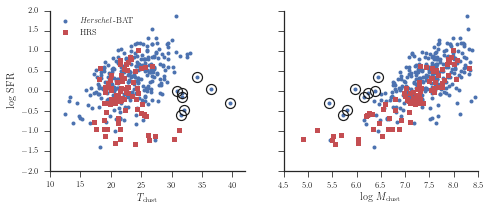

In [14]:
fig = plt.figure(figsize=(1.1*textwidth, 1.1*3./8.*textwidth))
ax1 = fig.add_subplot(121)
bat_casey['SFR/L500'] = bat_casey['SFR']-np.log10(4*np.pi*(bat_casey['Dist']*10**6*3.09e18)**2*(3e10/500e-4)*bat_casey['PLW']*10**-23/3.826e33)
hrs_mass_select['SFR/L500'] = hrs_mass_select['SFR']-np.log10(4*np.pi*(np.array(hrs_mass_select['Dist'], dtype=np.float)*10**6*3.09e18)**2*(3e10/500e-4)*np.array(hrs_mass_select['S500'], dtype=np.float)*10**-26/3.826e33)
ax1.plot(bat_casey['tdust'][bat_casey['lir_sf_flag'] != -1],
         bat_casey['SFR'][bat_casey['lir_sf_flag'] != -1], 'bo', label=r'\textit{Herschel}-BAT', ms=4)
#plt.plot(bat_casey['tdust'][bat_casey['lir_sf_flag'] == -1],
#         bat_casey['SFR'][bat_casey['lir_sf_flag'] == -1], 'bv')

ax1.plot(hrs_mass_select['tdust'][hrs_mass_select['Flag'] == 0],
         hrs_mass_select['SFR'][hrs_mass_select['Flag'] == 0],
         'rs', label=r'HRS', ms=5)
#plt.plot(hrs_mass_select['tdust'][hrs_mass_select['Flag'] == -1],
#         hrs_mass_select['SFR'][hrs_mass_select['Flag'] == -1],
#         'rv')
#plt.axhline(0.47)

ax1.plot(bat_casey['tdust'][(bat_casey['lir_sf_flag'] != -1) & (bat_casey['SFR'] < 0.47) & (bat_casey['tdust'] > 30)],
         bat_casey['SFR'][(bat_casey['lir_sf_flag'] != -1) & (bat_casey['SFR'] < 0.47) & (bat_casey['tdust'] > 30)],
         label='_nolabel', mew=1.2, ms=10, mfc='None', mec='k', marker='o', ls='None')

sn.despine()
ax1.set_xlabel(r'$T_{\rm dust}$')
ax1.set_ylabel(r'$\log\, {\rm SFR}$')
ax1.legend(loc='upper left')
ax1.set_ylim(-2, 2)
ax1.set_xlim(10, 42)

ax2 = fig.add_subplot(122)
ax2.set_ylim(-2, 2)
ax2.plot(bat_casey['mdust'][bat_casey['mdust_flag'] != -1],
        bat_casey['SFR'][bat_casey['mdust_flag']!=-1], 'bo', ms=4)
ax2.plot(np.array(hrs_mass_select['mdust'][hrs_mass_select['Flag'] == 0],dtype=np.float64),
           np.array(hrs_mass_select['SFR'][hrs_mass_select['Flag']==0], dtype=np.float64),
           'rs', ms=5)
#sn.regplot(bat_casey['mdust'][bat_casey['mdust_flag'] != -1]-bat_casey['Mstar'][bat_casey['mdust_flag'] != -1],
#           bat_casey['SFR'][bat_casey['mdust_flag']!=-1], x_bins=5,scatter=True)
#sn.regplot(np.array(hrs_mass_select['mdust'][hrs_mass_select['Flag'] == 0]-hrs_mass_select['Mstar'][hrs_mass_select['Flag'] == 0], dtype=np.float64),
#           np.array(hrs_mass_select['SFR'][hrs_mass_select['Flag']==0], dtype=np.float64),
#           color='r', x_bins=5, scatter=True)
sn.despine()
ax2.plot(bat_casey['mdust'][(bat_casey['lir_sf_flag'] != -1) & (bat_casey['SFR'] < 0.47) & (bat_casey['tdust'] > 30)],
         bat_casey['SFR'][(bat_casey['lir_sf_flag'] != -1) & (bat_casey['SFR'] < 0.47) & (bat_casey['tdust'] > 30)],
         label='_nolabel', mew=1.2, ms=10, mfc='None', mec='k', marker='o', ls='None')
ax2.set_xlabel(r'$\log$ $M_{\rm dust}$')
ax2.tick_params(axis='y', labelleft='off')
#ax2.set_ylabel(r'$\log$ SFR')
#ax2.legend([r'\textit{Herschel}-BAT', 'HRS' ], loc='upper left')
fig.savefig('../figures/sfr_vs_tdust_and_mdust.pdf', bbox_inches='tight')

In [101]:
bat_casey[(bat_casey['tdust'] > 30) & (bat_casey['SFR'] < 0.47)]

,mdust,mdust_err_high,mdust_err_low,mdust_flag,tdust,tdust_err_high,tdust_err_low,tdust_flag,alpha,alpha_err_high,...,lir_agn_flag,agn_frac,agn_frac_err_high,agn_frac_err_low,agn_frac_flag,PLW,Dist,Mstar,SFR,SFR/L500
Name,,,,,,,,,,,,,,,,,,,,,
2MASXJ09235371-3141305,6.371580,0.154169,0.169862,0,30.803178,2.184366,2.247172,0,1.625823,0.476591,...,0,0.229102,0.179606,0.105343,0,NaN,187.311041,NaN,0.012091,NaN
2MASXJ15462424+6929102,6.243658,0.350000,0.295600,0,31.747861,4.708328,7.679177,0,2.662326,0.605178,...,0,0.609905,0.237001,0.221827,0,NaN,164.706192,NaN,-0.051242,NaN
ESO103-035,5.977146,0.127866,0.099910,0,36.450793,3.870583,4.095540,0,2.944966,0.691178,...,0,0.815442,0.066474,0.100300,0,NaN,57.483713,NaN,0.047383,NaN
ESO417-G006,5.720920,0.206881,0.125101,0,31.502232,2.556212,5.813796,0,1.932294,0.430696,...,0,0.472159,0.276243,0.178132,0,NaN,70.646041,NaN,-0.599666,NaN
MCG-05-23-016,5.426143,0.093423,0.059249,0,39.655717,1.954886,3.705516,0,2.412120,0.752443,...,0,0.769498,0.074723,0.065400,0,NaN,36.581700,10.064171,-0.294416,NaN
MCG-06-30-015,5.798031,0.076204,0.049792,0,32.006002,1.261856,2.350701,0,1.559776,0.723189,...,0,0.670900,0.086865,0.076817,0,NaN,33.385772,NaN,-0.479593,NaN
Mrk841,6.441773,0.181436,0.127808,0,34.211263,3.674066,4.414828,0,1.971929,0.574025,...,0,0.800574,0.069902,0.081340,0,NaN,160.332507,NaN,0.353933,NaN
NGC3516,6.148504,0.069830,0.055584,0,31.716088,1.091361,1.838481,0,1.580741,0.678552,...,0,0.542211,0.102036,0.079114,0,NaN,38.900000,10.833543,-0.144100,NaN


In [93]:
hrs_mass_select[(hrs_mass_select['SFR'] < -1) & (hrs_mass_select['Flag'] == 0)]

,agn_frac,alpha,alpha_16,alpha_84,lir_bb,lir_bb_16,lir_bb_84,lir_powlaw,lir_powlaw_16,lir_powlaw_84,...,wturn,wturn_16,wturn_84,Flag,Mstar,Dist,S500,HRS ID,SFR,SFR/L500
Name,,,,,,,,,,,,,,,,,,,,,
ARK347,NaN,-0.651423,-0.989255,-0.231947,8.52583,8.4706,8.57713,8.24554,8.23072,8.27046,...,46.2244,28.6849,66.0344,0,10.62,17,48.6,231,-1.11598,-7.53805
Fairall272,NaN,-0.426739,-0.70093,0.0302146,8.41648,8.35331,8.44686,8.24174,8.22183,8.27191,...,45.5506,27.369,65.2459,0,10.48,20.2,102.8,22,-1.18606,-8.08328
MCG-01-05-047,NaN,-0.748629,-1.1242,-0.381512,8.19068,8.10785,8.21023,8.44699,8.42703,8.47241,...,46.5591,31.3732,63.6574,0,10.88,18.71,25,186,-1.18642,-7.40304
Mrk1210,NaN,-0.714496,-1.21592,-0.198658,8.60796,8.52301,8.66642,8.0256,8.0023,8.05644,...,44.6599,27.9427,63.4078,0,10.06,17,215.7,185,-1.11604,-8.18533
NGC235A,NaN,-0.777921,-1.1443,-0.378763,8.58253,8.53724,8.60069,8.19002,8.19291,8.22499,...,46.6024,31.0372,63.9733,0,10.58,17,44,180,-1.09471,-7.47359
NGC3786,NaN,-0.680658,-1.11597,-0.261965,8.42135,8.35678,8.47284,8.15464,8.12166,8.165,...,46.6548,30.4833,66.0211,0,10.29,17,64.9,129,-1.21574,-7.76342
NGC4102,NaN,0.301358,0.0411312,0.606133,8.23951,8.1502,8.29731,8.13749,8.10083,8.17178,...,46.8678,32.0591,64.673,0,10.12,19.16,33.4,14,-1.3324,-7.69547
UGC12741,NaN,-0.220644,-0.537445,0.206472,8.31541,8.29362,8.41759,8.13756,8.11548,8.15251,...,46.7437,28.7426,65.4246,0,10.21,16.7,79.9,3,-1.28837,-7.91088


In [94]:
hrs_info.loc[hrs_mass_select.loc[(hrs_mass_select['SFR'] < -1) & (hrs_mass_select['Flag'] == 0), 'HRS ID']]

,CGCG,VCC,UGC,NGC,IC,Dist_Mpc,BAT_flux,Type,E_BV,a,...,err_inst250,err_inst350,err_inst500,err_conf250,err_conf350,err_conf500,err_sky250,err_sky350,err_sky500,Note
HRS_1,,,,,,,,,,,,,,,,,,,,,
231,70206,1813,7828,4596,0,17.00,NaN,1,NaN,20.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-
22,155029,0,5959,3414,0,20.20,NaN,1,NaN,81.11,...,6.6,5.0,4.0,37.5,30.6,22.2,77.7,51.9,18.5,-
186,129005,0,7662,4494,0,18.71,NaN,0,NaN,26.15,...,2.4,1.8,1.4,13.0,11.0,7.2,14.8,9.3,4.0,-
185,42141,1330,7656,4492,0,17.00,NaN,3,0.025,82.32,...,10.5,7.6,6.1,40.5,33.1,24.2,89.6,63.3,35.1,-
180,70129,1253,7638,4477,0,17.00,NaN,1,NaN,55.87,...,7.6,5.4,4.4,29.2,23.9,17.5,37.3,29.3,13.4,-
129,99038,685,7473,4350,0,17.00,NaN,1,NaN,20.00,...,0.0,0.0,2.8,0.0,0.0,14.6,0.0,0.0,15.7,*
14,124045,0,5767,3301,0,19.16,NaN,2,NaN,42.87,...,3.7,3.0,2.3,21.1,17.4,12.7,10.2,16.3,7.2,-
3,94026,0,5617,3226,0,16.70,NaN,0,NaN,39.36,...,3.5,2.5,2.0,19.3,15.7,11.2,27.5,17.9,7.7,-


In [104]:
hrs_info['Flag100']

HRS_1
1      1
2      1
3      0
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     2
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     1
30     1
31     1
32     1
33     1
34     1
35     1
36     1
37     1
38     1
39     1
40     1
41     1
42     1
43     0
44     1
45     1
46     1
47     1
48     1
49     0
50     1
51     1
52     1
53     1
54     1
55     1
56     1
57     1
58     1
59     1
60     1
61     1
62     1
63     1
64     1
65     1
66     1
67     1
68     1
69     1
70     1
71     1
72     1
73     1
74     1
75     1
76     1
77     1
78     1
79     1
80     1
81     1
82     1
83     1
84     1
85     1
86     1
87     1
88     1
89     1
90     0
91     1
92     1
93     1
94     1
95     1
96     1
97     1
98     1
99     1
100    1
101    0
102    1
103    1
104    0
105    0
106    1
107    1
108    1
109    1
110    1
111    1
112 